In [1]:
import os
import torch
import torch.utils.data as data
import torch
import torchvision.transforms as transforms
import random
from PIL import Image, ImageOps
import numpy as np
import cv2

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG', '.jpeg', '.bmp'])

def rgb_loader(img_path):
    assert(is_image_file(img_path)==True)
    return Image.open(img_path).convert('RGB')

def gray_loader(img_path):
    assert(is_image_file(img_path)==True)
    return Image.open(img_path).convert('L')

class loadImgs(data.Dataset):
    def __init__(self, 
                 args, 
                 imgin_list, 
                 mode='demo'):
        self.imgin_list  = imgin_list
        self.args        = args
        self.mode        = mode
        
        if self.args.use_gray:
            self.img_loader  = gray_loader
        else:
            self.img_loader  = rgb_loader

        self.data_list   = {'img_in': []}
        random.seed(141)
        for num_img in range(len(self.imgin_list)):
            self.data_list['img_in'].append(self.imgin_list[num_img])

    def __getitem__(self, index):
        img_in_path = self.data_list['img_in'][index]

        if self.mode == 'demo':
            img_in  = self.img_loader(img_in_path)
            if self.args.load_size != 'None':
                w, h      = img_in.size
                img_in    = img_in.resize((512, 512))
            if self.args.crop_size != 'None':
                w, h      = img_in.size
                crop_size = self.args.crop_size.strip('[]').split(', ')
                crop_size = [int(item) for item in crop_size]
                th, tw    = crop_size[0], crop_size[1]
                x1        = random.randint(0, w - tw)
                y1        = random.randint(0, h - th)
                img_in    = img_in.crop((x1, y1, x1 + tw, y1 + th))
        elif self.mode == 'val':
            raise NotImplementedError
        elif self.mode == 'predict':
            img_in  = self.img_loader(img_in_path)
        else:
            print('Unrecognized mode! Please select among: (demo, val, predict)')
            raise NotImplementedError

        t_list = [transforms.ToTensor()]
        composed_transform  = transforms.Compose(t_list)
        if self.mode == 'demo':
            img_in = composed_transform(img_in)
        if self.mode == 'val':
            raise NotImplementedError
        if self.mode == 'predict':
            img_in = composed_transform(img_in)

        if self.mode == 'demo':
            inputs = {'img_in': img_in}
            return inputs
        if self.mode == 'predict':
            inputs = {'img_in': img_in}
    def __len__(self):
        return len(self.data_list['img_in'])

img_name ./light-effects/DSC00701.JPG


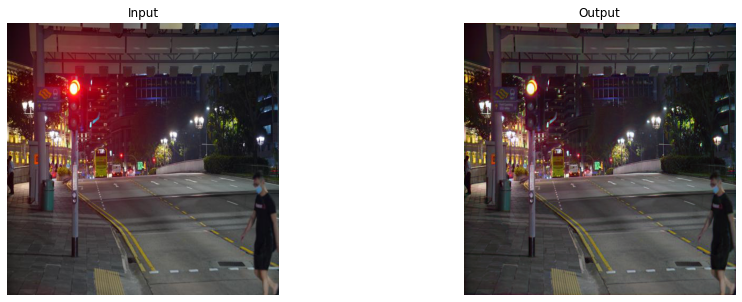

img_name ./light-effects/DSC00983.JPG


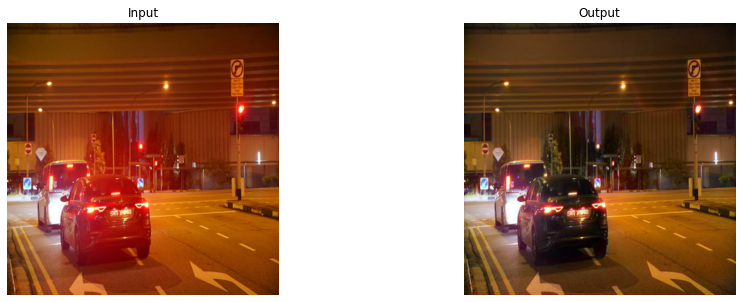

img_name ./light-effects/DSC01173.JPG


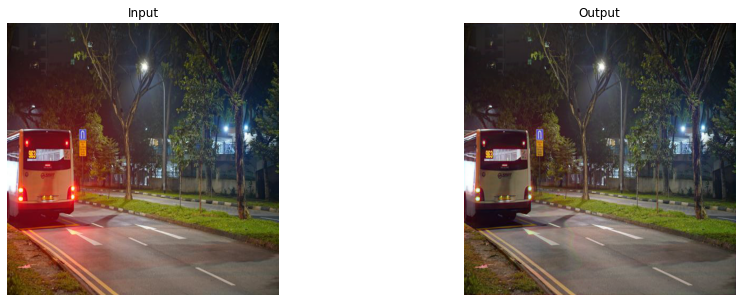

img_name ./light-effects/DSC01331.JPG


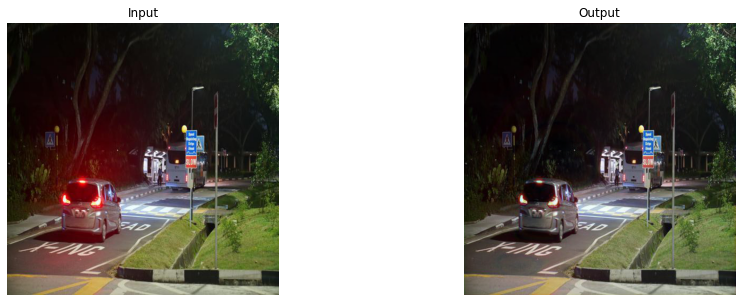

img_name ./light-effects/DSC01419.JPG


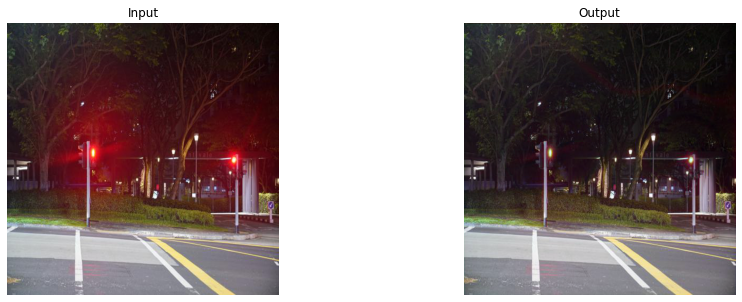

img_name ./light-effects/DSC01609.JPG


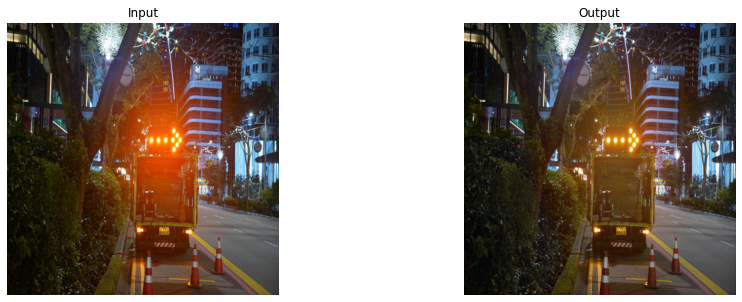

img_name ./light-effects/DSC01701.JPG


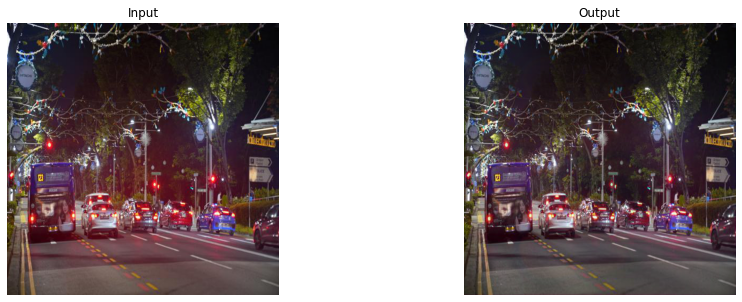

img_name ./light-effects/DSC01713.JPG


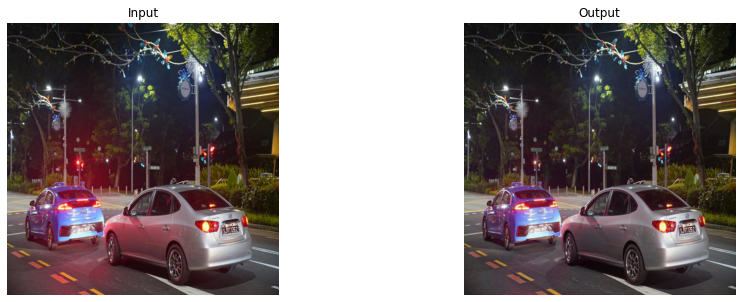

img_name ./light-effects/GOPR0364_frame_000939_rgb_anon.png


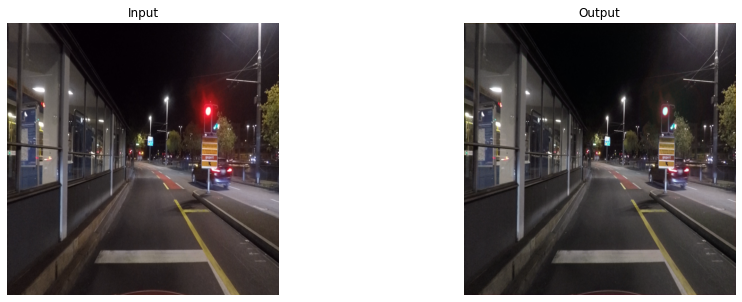

In [2]:
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from os import makedirs, listdir
from os.path import join, isfile, basename, exists
import argparse
import skimage
import PIL
from torchvision import utils as vutils
import load_data as DA
from Net import *
import matplotlib.pyplot as plt

class MeanShift(nn.Conv2d):
    def __init__(self, data_mean, data_std, data_range=1, norm=True):
        c = len(data_mean)
        super(MeanShift, self).__init__(c, c, kernel_size=1)
        std = torch.Tensor(data_std)
        self.weight.data = torch.eye(c).view(c, c, 1, 1)
        if norm:
            self.weight.data.div_(std.view(c, 1, 1, 1))
            self.bias.data = -1 * data_range * torch.Tensor(data_mean)
            self.bias.data.div_(std)
        else:
            self.weight.data.mul_(std.view(c, 1, 1, 1))
            self.bias.data = data_range * torch.Tensor(data_mean)
        self.requires_grad = False
        
class ExclusionLoss(nn.Module):
    def __init__(self, level=3):
        super(ExclusionLoss, self).__init__()
        self.level = level
        self.avg_pool = torch.nn.AvgPool2d(2, stride=2).type(torch.cuda.FloatTensor)
        self.sigmoid = nn.Sigmoid().type(torch.cuda.FloatTensor)

    def get_gradients(self, img1, img2):
        gradx_loss = []
        grady_loss = []

        for l in range(self.level):
            gradx1, grady1 = self.compute_gradient(img1)
            gradx2, grady2 = self.compute_gradient(img2)
            alphay = 1
            alphax = 1
            gradx1_s = (self.sigmoid(gradx1) * 2) - 1
            grady1_s = (self.sigmoid(grady1) * 2) - 1
            gradx2_s = (self.sigmoid(gradx2 * alphax) * 2) - 1
            grady2_s = (self.sigmoid(grady2 * alphay) * 2) - 1
            gradx_loss += self._all_comb(gradx1_s, gradx2_s)
            grady_loss += self._all_comb(grady1_s, grady2_s)
            img1 = self.avg_pool(img1)
            img2 = self.avg_pool(img2)
        return gradx_loss, grady_loss

    def _all_comb(self, grad1_s, grad2_s):
        v = []
        for i in range(3):
            for j in range(3):
                v.append(torch.mean(((grad1_s[:, j, :, :] ** 2) * (grad2_s[:, i, :, :] ** 2))) ** 0.25)
        return v

    def forward(self, img1, img2):
        gradx_loss, grady_loss = self.get_gradients(img1, img2)
        loss_gradxy = sum(gradx_loss) / (self.level * 9) + sum(grady_loss) / (self.level * 9)
        return loss_gradxy / 2.0

    def compute_gradient(self, img):
        gradx = img[:, :, 1:, :] - img[:, :, :-1, :]
        grady = img[:, :, :, 1:] - img[:, :, :, :-1]
        return gradx, grady
    
def gradient(pred):
    D_dy      = pred[:, :, 1:] - pred[:, :, :-1]
    D_dx      = pred[:, :, :, 1:] - pred[:, :, :, :-1]
    return D_dx, D_dy

def smooth_loss(pred_map):
    dx, dy   = gradient(pred_map)
    dx2, dxdy= gradient(dx)
    dydx, dy2= gradient(dy)
    loss     =  (dx2.abs().mean()  + dxdy.abs().mean()+ 
                 dydx.abs().mean() + dy2.abs().mean())
    return loss

def rgb2gray(rgb):
    gray = 0.2989*rgb[:,:,0:1,:] + \
    	   0.5870*rgb[:,:,1:2,:] + \
    	   0.1140*rgb[:,:,2:3,:]
    return gray

def demo(args,
         dle_net,
         optimizer_dle_net,
         inputs):
    
    dle_net.train()

    img_in    = Variable(torch.FloatTensor(inputs['img_in'])).cuda()
    optimizer_dle_net.zero_grad()

    le_pred = dle_net(img_in)
    dle_pred= img_in + le_pred

    lambda_cc         = 1.0 
    dle_pred_cc       = torch.mean(dle_pred, dim=1, keepdims=True)
    cc_loss           = (F.l1_loss(dle_pred[:, 0:1, :, :], dle_pred_cc) + \
                         F.l1_loss(dle_pred[:, 1:2, :, :], dle_pred_cc) + \
                         F.l1_loss(dle_pred[:, 2:3, :, :], dle_pred_cc))*(1/3) ##Color Constancy Loss

    lambda_recon        = 1.0
    recon_loss          = F.l1_loss(dle_pred, img_in)                         
    
    lambda_excl        = 0.01
    data_type          = torch.cuda.FloatTensor
    excl_loss          = ExclusionLoss().type(data_type)                      

    lambda_smooth       = 1.0 
    le_smooth_loss      = smooth_loss(le_pred)

    loss = lambda_recon*recon_loss + \
           lambda_cc*cc_loss
    loss += lambda_excl * excl_loss(dle_pred, le_pred)
    loss += lambda_smooth*le_smooth_loss
    loss.backward()

    optimizer_dle_net.step()

    imgs_dict   = {}
    imgs_dict['dle_pred'] = dle_pred.detach().cpu()
    return imgs_dict

class Arguments:
    def __init__(self):
        self.out_dir = './light-effects-output/'
        self.data_dir = './light-effects/'
        self.load_model = None
        self.load_size = "Resize"
        self.crop_size = "[512, 512]"
        self.iters = 60
        self.learning_rate = 1e-4

args = Arguments()

args.imgin_dir = args.data_dir
args.use_gray  = False

torch.manual_seed(0)

args.imgs_dir = args.out_dir
if not os.path.exists(args.imgs_dir):
    os.makedirs(args.imgs_dir)

if args.use_gray:
    channels = 1
else:
    channels = 3
dle_net = Net(input_nc=channels, output_nc=channels)
dle_net = nn.DataParallel(dle_net).cuda()

if args.load_model is not None:
    dle_net_ckpt_file = args.load_model
    dle_net.load_state_dict(torch.load(dle_net_ckpt_file)['state_dict'])

optimizer_dle_net = optim.Adam(dle_net.parameters(), 
                                  lr=args.learning_rate, 
                                  betas=(0.9, 0.999))

in_filenames = sorted([join(args.imgin_dir, x) for x in listdir(args.imgin_dir) if is_image_file(x)])

for in_filename in in_filenames:
    img_name = basename(in_filename)
    print('img_name',in_filename)
    img = Image.open(in_filename).convert('RGB')
    w, h = img.size

    if h != 512 or w != 512:
        img = img.resize([512, 512], Image.LANCZOS)  

    da_list  = sorted([(args.imgin_dir+ file) for file in os.listdir(args.imgin_dir) \
                        if file == img_name])
    demo_list   = da_list
    demo_list   = demo_list*args.iters

    Dele_Loader  = torch.utils.data.DataLoader(DA.loadImgs(args, 
                                                           demo_list,
                                                           mode='demo'),
                                               batch_size  = 1, 
                                               shuffle     = True, 
                                               num_workers = 16, 
                                               drop_last   = False)
    count_idx = 0
    tbar = Dele_Loader
    for batch_idx, inputs in enumerate(tbar):
        count_idx = count_idx + 1
        imgs_dict = demo(args,
                          dle_net, 
                          optimizer_dle_net,
                          inputs)

        if (count_idx%60 == 0):
            inout = os.path.join(args.imgs_dir, img_name[:-4]+'_in_out')
            out   = os.path.join(args.imgs_dir, img_name[:-4]+'_out')
            save_img   = torch.cat((inputs['img_in'][0, :, :, :],
                                    imgs_dict['dle_pred'][0, :, :, :]), dim=2)
            in_img  = inputs['img_in'][0, :, :, :]
            out_img = imgs_dict['dle_pred'][0, :, :, :]
            test = in_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
            test = Image.fromarray(test)
            test = test.resize([w, h], Image.LANCZOS)
            result = out_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
            result = Image.fromarray(result)
            result = result.resize([w, h], Image.LANCZOS)

            vutils.save_image(save_img, inout+'.png')
            vutils.save_image(out_img, out+'.png')
            
            in_img_np = in_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
            out_img_np = out_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            axs[0].imshow(in_img_np)
            axs[0].set_title('Input')
            axs[0].axis('off')
            axs[1].imshow(out_img_np)
            axs[1].set_title('Output')
            axs[1].axis('off')
            plt.show()